In [184]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from random import seed
keras = tf.keras
execfile("./windowgenerator.py")
execfile("./tf_models.py")

DATA_PATHS = ["data/mpi_roof_2023b.csv"]
MAX_EPOCHS = 20
OUT_STEPS = 24
FEATURES = ['rain (mm)']
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(1224)

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

                       count         mean         std          min  \
p (mbar)              4439.0   986.116355    9.283638   952.510000   
T (degC)              4439.0    13.354039    7.767433    -5.600000   
Tpot (K)              4439.0   287.653118    7.703306   267.960000   
Tdew (degC)           4439.0     9.147083    5.609183    -6.450000   
rh (%)                4439.0    78.750122   18.188750    24.110000   
VPmax (mbar)          4439.0    17.114377    8.593628     4.020000   
VPact (mbar)          4439.0    12.326112    4.412037     3.760000   
VPdef (mbar)          4439.0     4.788169    6.251875     0.000000   
sh (g/kg)             4439.0     7.813618    2.797825     2.370000   
H2OC (mmol/mol)       4439.0    12.495161    4.452634     3.800000   
rho (g/m**3)          4439.0  1194.227806   34.245032  1107.230000   
max. wv (m/s)         4439.0     3.719320    2.488111     0.250000   
rain (mm)             4439.0     0.013179    0.114003     0.000000   
raining (s)         

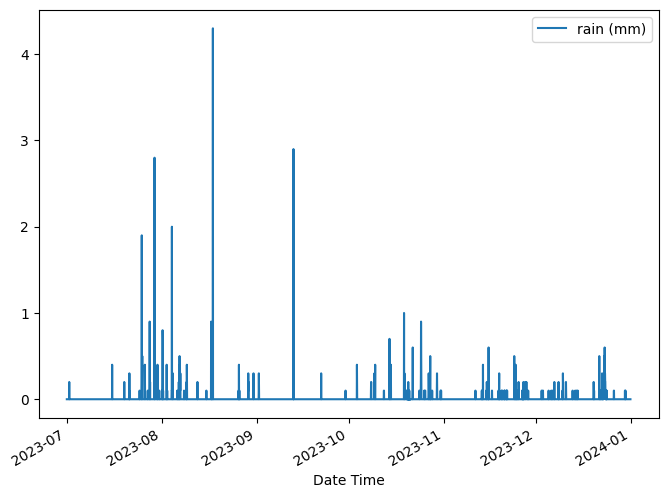

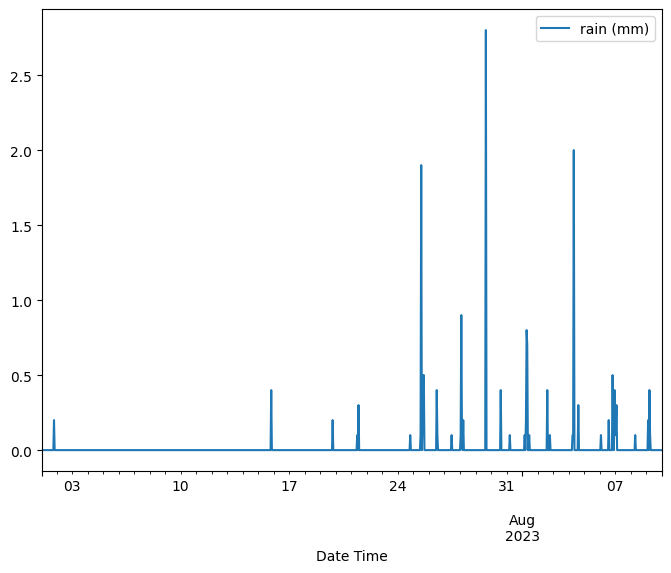

In [185]:
csvs = (pd.read_csv(f, encoding='ansi') for f in DATA_PATHS)
df = pd.concat(csvs, ignore_index=True)

df = df[5::6] # Slice down to every 6th record (every hour) starting from index 5 to enable hourly predictions
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

# Feature engineering
# Combine wind velocity and direction scalars into a vector for ease of processing
wv = df.pop('wv (m/s)')
wd_rad = df.pop('wd (deg)') * np.pi / 180

df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

print(df.describe().transpose())

# Data split
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
df_train = df[0:int(0.7 * n)]
df_valid = df[int(0.7 * n):int(0.9 * n)]
df_test = df[int(0.9 * n):]
num_features = df.shape[1]

plot_cols = FEATURES
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:960]
plot_features.index = date_time[:960]
_ = plot_features.plot(subplots=True)


C:\Users\Harrison\AppData\Local\Temp\ipykernel_3960\4006364998.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


                  count          mean  std       min       25%       50%  \
p (mbar)         3091.0  4.022807e-15  1.0 -3.837403 -0.463774  0.135230   
T (degC)         3091.0  1.103399e-16  1.0 -2.879321 -0.758839 -0.098718   
rh (%)           3091.0  2.022897e-16  1.0 -2.661165 -0.701018  0.218083   
sh (g/kg)        3091.0  1.103399e-16  1.0 -2.467776 -0.701218 -0.122157   
Tpot (K)         3091.0  2.574597e-16  1.0 -2.966321 -0.706618 -0.102196   
Tdew (degC)      3091.0 -1.103399e-16  1.0 -3.556843 -0.647284  0.000696   
VPmax (mbar)     3091.0 -2.942396e-16  1.0 -1.708506 -0.746694 -0.249477   
VPact (mbar)     3091.0 -7.355991e-17  1.0 -2.456030 -0.696749 -0.112078   
VPdef (mbar)     3091.0  3.677995e-17  1.0 -0.762275 -0.762275 -0.389082   
H2OC (mmol/mol)  3091.0 -4.045795e-16  1.0 -2.478643 -0.703434 -0.119623   
rho (g/m**3)     3091.0  1.360858e-15  1.0 -2.761523 -0.681489 -0.011387   
rain (mm)        3091.0 -1.838998e-17  1.0 -0.112988 -0.112988 -0.112988   
SWDR (W/m**2

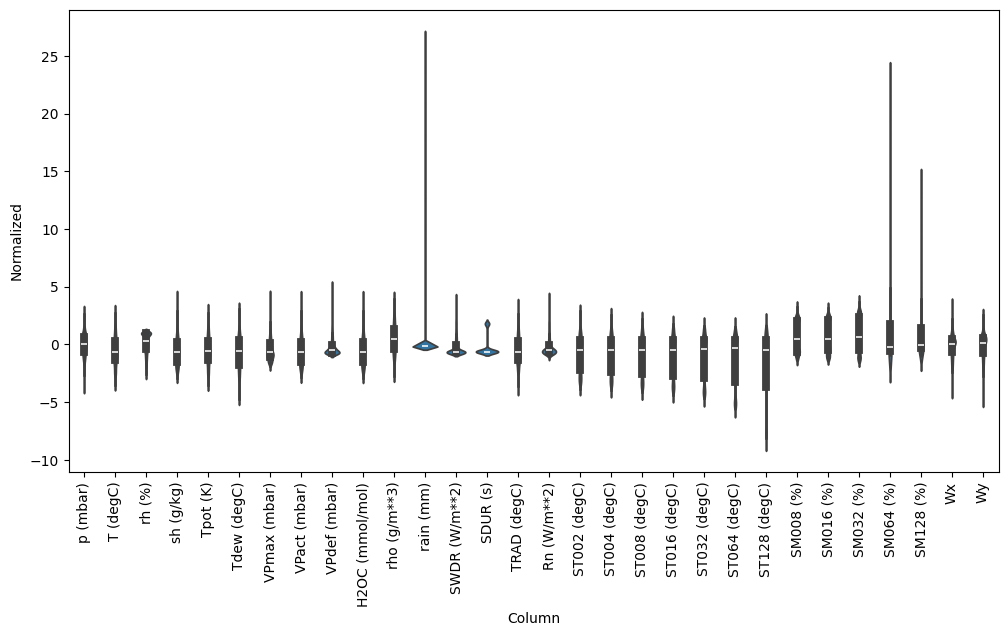

In [163]:
# Normalization
mean = df_train.mean()
std = df_train.std()
df_train = (df_train - mean) / std
df_valid = (df_valid - mean) / std
df_test = (df_test - mean) / std

df_std = (df - mean) / std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

print(df_train.describe().transpose())

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['rain (mm)']


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_45 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_33 (Reshape)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0348 - mean_absolute_error: 0.2046 - val_loss: 0.5768 - val_mean_absolute_error: 0.1966
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9732 - mean_absolute_error: 0.1889 - val_loss: 0.5758 - val_mean_absolute_error: 0.2113
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9910 - mean_absolute_error: 0.1850 - val_loss: 0.5806 - val_mean_absolute_error: 0.1999
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9960 - mean_absolute_error: 0.1957 - val_loss: 0.5804 - val_mean_absolute_error: 0.2132
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6111 - mean_absolute_error: 0.2202 
Validation performance: {'loss': 0.5803505182266235, 'mean_absolute_error': 0.21319743990898132}
Test performance: {'loss': 0.415549099445343, 'mean_absolute_error': 0.2310684770345688}


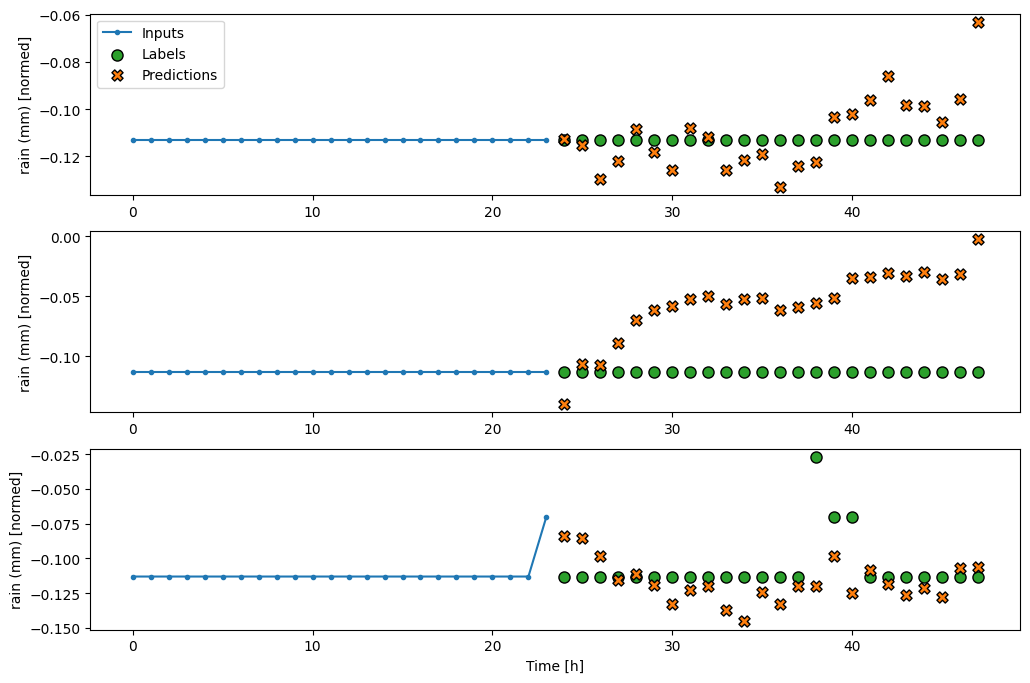

In [167]:
# Model initialization and training

window = WindowGenerator(
    input_width=24, label_width=24, shift=OUT_STEPS,
    label_columns = FEATURES,
    train_df=df_train, val_df=df_valid, test_df=df_test
)
print(window)

model = keras.Sequential([
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, num_features])
])

model.summary()
compile_and_fit(model, window)

val_performance = model.evaluate(window.val, return_dict=True)
performance = model.evaluate(window.test, verbose=0, return_dict=True)


print("Validation performance:", val_performance)
print("Test performance:", performance)

for f in FEATURES:
    window.plot(model, f)

In [102]:
# Run to save the model's weights
model.save("./output/druid.keras")